In [1]:
import pandas as pd 
import numpy as np
from sqlalchemy import create_engine, text
from sqlalchemy import URL
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import h2o
from h2o.estimators import H2ORandomForestEstimator
from sklearn.utils import shuffle
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
def create_table(username, password,db_name):
    url_object = URL.create(
        "mysql+mysqlconnector",
        username=username,
        password=password,
        host="localhost",
        database=db_name
    )
    return create_engine(url_object)

In [3]:
engine = create_table('', '', 'TransferMarket')

# Part 1:

get data from database

In [60]:
query = """
SELECT pd.person_id, appearances, ppg, goals, own_goal, assists, substitutions_on, substitutions_off,
       yellow_cards, red_cards, penalty_goals, goals_conceded,
       clean_sheets, minutes_played, market_value, position,
       Foot , YEAR(CURDATE()) - YEAR(date) - (DATE_FORMAT(CURDATE(), '%m%d') < DATE_FORMAT(date, '%m%d')) AS age
FROM player
JOIN person_detail pd ON player.person_id = pd.person_id;
"""


player_details=pd.DataFrame(engine.connect().execute(text(query)))

In [61]:
player_details

,person_id,appearances,ppg,goals,own_goal,assists,substitutions_on,substitutions_off,yellow_cards,red_cards,penalty_goals,goals_conceded,clean_sheets,minutes_played,market_value,position,Foot,age
0,10,24,1.25,7,0,8,10,9,3,0,1,0,0,1359,1000000.0,Attack,right,44.0
1,10,24,1.25,7,0,8,10,9,3,0,1,0,0,1359,1000000.0,Attack,right,44.0
2,80,2,3.00,0,0,0,0,0,0,0,0,0,2,180,100000.0,Goalkeeper,right,42.0
3,80,2,3.00,0,0,0,0,0,0,0,0,2,0,180,200000.0,Goalkeeper,right,42.0
4,80,0,NaN,0,0,0,0,0,0,0,0,0,0,0,300000.0,Goalkeeper,right,42.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37023,1016446,0,NaN,0,0,0,0,0,0,0,0,0,0,0,None,Goalkeeper,Unknown,NaN
37024,1016515,0,NaN,0,0,0,0,0,0,0,0,0,0,0,None,Defender,Unknown,NaN
37025,1019537,22,1.23,0,0,0,5,2,3,0,0,0,0,1659,None,Defender,Unknown,30.0
37026,1023436,1,0.00,0,0,0,1,0,0,0,0,0,0,17,None,Defender,Unknown,NaN


Delete empty market_value records

In [62]:

player_details = player_details.dropna(subset=['market_value'])

In [63]:
player_details

,person_id,appearances,ppg,goals,own_goal,assists,substitutions_on,substitutions_off,yellow_cards,red_cards,penalty_goals,goals_conceded,clean_sheets,minutes_played,market_value,position,Foot,age
0,10,24,1.25,7,0,8,10,9,3,0,1,0,0,1359,1000000.0,Attack,right,44.0
1,10,24,1.25,7,0,8,10,9,3,0,1,0,0,1359,1000000.0,Attack,right,44.0
2,80,2,3.00,0,0,0,0,0,0,0,0,0,2,180,100000.0,Goalkeeper,right,42.0
3,80,2,3.00,0,0,0,0,0,0,0,0,2,0,180,200000.0,Goalkeeper,right,42.0
4,80,0,NaN,0,0,0,0,0,0,0,0,0,0,0,300000.0,Goalkeeper,right,42.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36906,933511,0,NaN,0,0,0,0,0,0,0,0,0,0,0,25000.0,Goalkeeper,left,24.0
36927,947358,0,NaN,0,0,0,0,0,0,0,0,0,0,0,50000.0,Attack,right,21.0
36928,947358,0,NaN,0,0,0,0,0,0,0,0,0,0,0,50000.0,Attack,right,21.0
36940,951579,2,0.00,0,0,0,1,1,1,1,0,0,0,96,200000.0,Defender,right,18.0


fill nan value in ppg and age column 

In [64]:
player_details = player_details.dropna(subset=['ppg'])
mean_age = player_details['age'].mean()
player_details['age'].fillna(mean_age, inplace=True)


C:\Users\Fatemeh\AppData\Local\Temp\ipykernel_6128\1796375381.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_details['age'].fillna(mean_age, inplace=True)


convert categorical to 0-1

In [65]:
player_details

,person_id,appearances,ppg,goals,own_goal,assists,substitutions_on,substitutions_off,yellow_cards,red_cards,penalty_goals,goals_conceded,clean_sheets,minutes_played,market_value,position,Foot,age
0,10,24,1.25,7,0,8,10,9,3,0,1,0,0,1359,1000000.0,Attack,right,44.0
1,10,24,1.25,7,0,8,10,9,3,0,1,0,0,1359,1000000.0,Attack,right,44.0
2,80,2,3.00,0,0,0,0,0,0,0,0,0,2,180,100000.0,Goalkeeper,right,42.0
3,80,2,3.00,0,0,0,0,0,0,0,0,2,0,180,200000.0,Goalkeeper,right,42.0
5,80,2,3.00,0,0,0,0,0,0,0,0,0,2,180,100000.0,Goalkeeper,right,42.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36802,908047,1,0.00,0,0,0,0,1,0,0,0,0,0,68,50000.0,Attack,Unknown,24.0
36804,908047,16,0.75,0,0,0,4,1,0,0,0,0,0,1144,50000.0,Attack,Unknown,24.0
36826,918871,2,0.00,0,0,0,0,1,0,0,0,0,0,108,200000.0,Defender,Unknown,23.0
36905,933511,2,0.00,0,0,0,0,0,0,0,0,3,0,180,25000.0,Goalkeeper,left,24.0


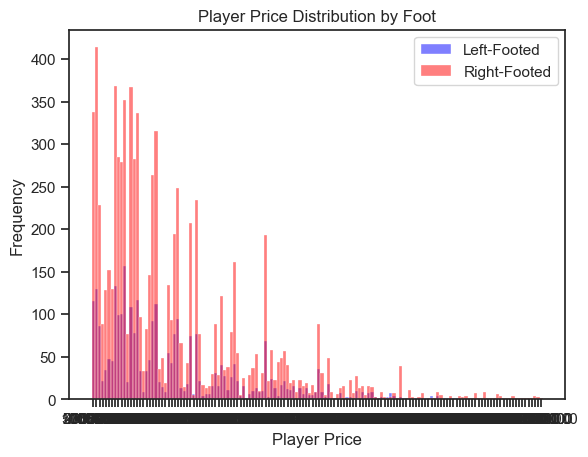

In [66]:
left_footed_players = player_details[player_details['Foot'] == 'left']
right_footed_players = player_details[player_details['Foot'] == 'right']
sns.set(style='ticks')
sns.histplot(data=left_footed_players, x='market_value', bins=20, color='blue', alpha=0.5, label='Left-Footed')
sns.histplot(data=right_footed_players, x='market_value', bins=20, color='red', alpha=0.5, label='Right-Footed')
plt.title('Player Price Distribution by Foot')
plt.xlabel('Player Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [67]:
player_details.drop(['Foot'],inplace=True,axis=1)

C:\Users\Fatemeh\AppData\Local\Temp\ipykernel_6128\1461442505.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_details.drop(['Foot'],inplace=True,axis=1)


In [68]:
player_details.loc[player_details['position'] == 'Goalkeeper', 'my'] = (player_details['clean_sheets'] * 2.5 + 2.5 *player_details['goals_conceded'])
player_details.loc[player_details['position'] == 'Attack', 'my'] = (player_details['goals'] * 3.5 + 1.5*player_details['assists'])
player_details.loc[player_details['position'] == 'midfield', 'my'] = (player_details['goals'] * 1.5 + 3.5 *player_details['assists'])
player_details.loc[player_details['position'] == 'Defender', 'my'] = (2.5 *player_details['assists']+player_details['goals'] * 2.5 )

C:\Users\Fatemeh\AppData\Local\Temp\ipykernel_6128\808186712.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_details.loc[player_details['position'] == 'Goalkeeper', 'my'] = (player_details['clean_sheets'] * 2.5 + 2.5 *player_details['goals_conceded'])


In [69]:
player_details['two'] = 2 *player_details['red_cards']+player_details['yellow_cards'] * 1 

C:\Users\Fatemeh\AppData\Local\Temp\ipykernel_6128\1698301173.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_details['two'] = 2 *player_details['red_cards']+player_details['yellow_cards'] * 1


In [70]:
status_dummy=pd.get_dummies(player_details['position'])
status_dummy = status_dummy.astype(int)
player_details.drop(['position'],inplace=True,axis=1)
player_details = pd.concat([player_details, status_dummy], axis=1)


C:\Users\Fatemeh\AppData\Local\Temp\ipykernel_6128\3850689897.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_details.drop(['position'],inplace=True,axis=1)


data exploring

In [71]:
player_details.head()

,person_id,appearances,ppg,goals,own_goal,assists,substitutions_on,substitutions_off,yellow_cards,red_cards,...,clean_sheets,minutes_played,market_value,age,my,two,Attack,Defender,Goalkeeper,midfield
0,10,24,1.25,7,0,8,10,9,3,0,...,0,1359,1000000.0,44.0,36.5,3,1,0,0,0
1,10,24,1.25,7,0,8,10,9,3,0,...,0,1359,1000000.0,44.0,36.5,3,1,0,0,0
2,80,2,3.00,0,0,0,0,0,0,0,...,2,180,100000.0,42.0,5.0,0,0,0,1,0
3,80,2,3.00,0,0,0,0,0,0,0,...,0,180,200000.0,42.0,5.0,0,0,0,1,0
5,80,2,3.00,0,0,0,0,0,0,0,...,2,180,100000.0,42.0,5.0,0,0,0,1,0


<AxesSubplot: >

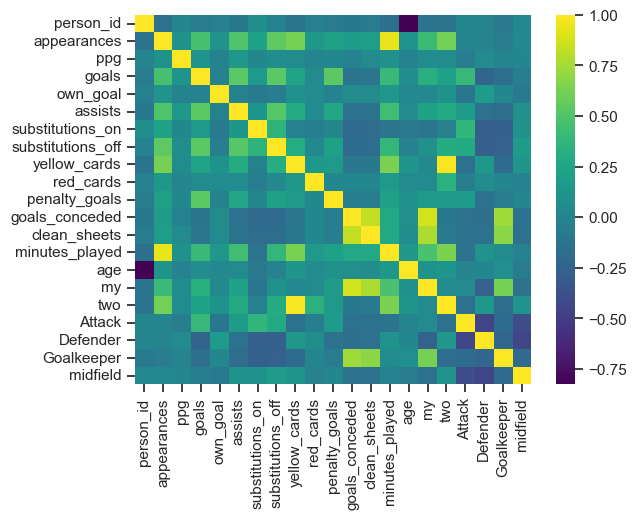

In [73]:
sns.heatmap(player_details.corr(), cmap='viridis')

In [74]:
player_details.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11898 entries, 0 to 36940
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   person_id          11898 non-null  int64  
 1   appearances        11898 non-null  int64  
 2   ppg                11898 non-null  float64
 3   goals              11898 non-null  int64  
 4   own_goal           11898 non-null  int64  
 5   assists            11898 non-null  int64  
 6   substitutions_on   11898 non-null  int64  
 7   substitutions_off  11898 non-null  int64  
 8   yellow_cards       11898 non-null  int64  
 9   red_cards          11898 non-null  int64  
 10  penalty_goals      11898 non-null  int64  
 11  goals_conceded     11898 non-null  int64  
 12  clean_sheets       11898 non-null  int64  
 13  minutes_played     11898 non-null  int64  
 14  market_value       11898 non-null  object 
 15  age                11898 non-null  float64
 16  my                 118

In [75]:
player_details.describe()

,person_id,appearances,ppg,goals,own_goal,assists,substitutions_on,substitutions_off,yellow_cards,red_cards,...,goals_conceded,clean_sheets,minutes_played,age,my,two,Attack,Defender,Goalkeeper,midfield
count,11898.000000,11898.000000,11898.000000,11898.000000,11898.000000,11898.000000,11898.000000,11898.00000,11898.000000,11898.000000,...,11898.000000,11898.000000,11898.000000,11898.000000,11898.000000,11898.000000,11898.000000,11898.000000,11898.00000,11898.000000
mean,205108.815935,18.101193,1.293485,1.629349,0.045050,1.146999,4.029165,4.09800,2.480669,0.078501,...,1.864515,0.388217,1261.436712,30.220685,13.090225,2.637670,0.287611,0.333501,0.08825,0.290637
std,161961.006038,11.307942,0.600218,2.999390,0.218474,1.892059,4.410637,4.57274,2.613291,0.285346,...,8.105091,1.833991,969.066825,4.979766,25.483241,2.750855,0.452668,0.471484,0.28367,0.454075
min,10.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,68645.000000,8.000000,0.970000,0.000000,0.000000,0.000000,1.000000,1.00000,0.000000,0.000000,...,0.000000,0.000000,386.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,170955.000000,18.000000,1.260000,0.000000,0.000000,0.000000,3.000000,2.00000,2.000000,0.000000,...,0.000000,0.000000,1098.000000,30.000000,5.000000,2.000000,0.000000,0.000000,0.00000,0.000000
75%,298884.500000,28.000000,1.620000,2.000000,0.000000,2.000000,6.000000,6.00000,4.000000,0.000000,...,0.000000,0.000000,2004.750000,34.000000,13.500000,4.000000,1.000000,1.000000,0.00000,1.000000
max,951579.000000,46.000000,3.000000,36.000000,2.000000,17.000000,30.000000,29.00000,19.000000,3.000000,...,74.000000,22.000000,4140.000000,47.000000,207.500000,19.000000,1.000000,1.000000,1.00000,1.000000


determine features and target

In [76]:
y = player_details['market_value']
player_details.drop('market_value' ,inplace=True,axis=1)
player_details.drop('person_id' ,inplace=True,axis=1)
x= player_details

train test split

In [77]:
X_train, X_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2,random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5,random_state=42)

create and train model

In [82]:
param_grid = {
    'n_estimators': [50,100],
    'learning_rate': [0.1,0.2],
    'max_depth': [10,20,30],
    'min_child_weight': [5,7,9],
    'gamma': [0,0.01],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9]
}

model = XGBRegressor()

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2',n_jobs=10)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=10,
             param_grid={'colsample_bytree': [0.8, 0.9], 'gamma': [0, 0.01],
                         'learning_rate': [0.1, 0.2], 'max_depth': [10, 20, 30],
                         'min_child_weight': [5, 7, 9],
                         'n_estimators': [50, 100], 'subsample': [0.8, 0.9]},
             scoring='r2')

get the best model and the best params

In [83]:
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

In [84]:
print(best_params)

{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 20, 'min_child_weight': 7, 'n_estimators': 50, 'subsample': 0.8}


preidict y_val and get r2

In [85]:
y_pred = best_model.predict(X_val)

r2 = r2_score(y_val, y_pred)
print(r2)


0.5436454665426176


# Part 2: 

In [98]:
query = """
SELECT pd.person_id, appearances, ppg, goals, own_goal, assists, substitutions_on, substitutions_off,
       yellow_cards, red_cards, penalty_goals, goals_conceded,
       clean_sheets, minutes_played, market_value, position,
       Foot, YEAR(CURDATE()) - YEAR(date) - (DATE_FORMAT(CURDATE(), '%m%d') < DATE_FORMAT(date, '%m%d')) AS age
FROM player
JOIN person_detail pd ON player.person_id = pd.person_id;
"""


player_details1=pd.DataFrame(engine.connect().execute(text(query)))

In this section, we decided to give all the rows that did not have the market value to the model of the previous section and predict the value of the market value so that a large part of the data is preserved.

get all data with market value nan

In [99]:
player_details1 = player_details1.dropna(subset=['ppg'])

In [100]:
new_df = player_details1[player_details1['market_value'].isna()]

doing preprocecing 

In [101]:
new_df.loc[new_df['position'] == 'Goalkeeper', 'my'] = (new_df['clean_sheets'] * 2.5 + 2.5 *new_df['goals_conceded'])
new_df.loc[new_df['position'] == 'Attack', 'my'] = (new_df['goals'] * 3.5 + 1.5*new_df['assists'])
new_df.loc[new_df['position'] == 'midfield', 'my'] = (new_df['goals'] * 1.5 + 3.5 *new_df['assists'])
new_df.loc[new_df['position'] == 'Defender', 'my'] = (2.5 *new_df['assists']+new_df['goals'] * 2.5 )

C:\Users\Fatemeh\AppData\Local\Temp\ipykernel_6128\1538983080.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.loc[new_df['position'] == 'Goalkeeper', 'my'] = (new_df['clean_sheets'] * 2.5 + 2.5 *new_df['goals_conceded'])


In [102]:
new_df['two'] = 2 *new_df['red_cards']+new_df['yellow_cards'] * 1 

C:\Users\Fatemeh\AppData\Local\Temp\ipykernel_6128\4236452236.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['two'] = 2 *new_df['red_cards']+new_df['yellow_cards'] * 1


In [103]:

mean_age = new_df['age'].mean()
new_df['age'].fillna(mean_age, inplace=True)
position=new_df['position']
status_dummy=pd.get_dummies(new_df['position'])
status_dummy = status_dummy.astype(int)
new_df.drop(['position'],inplace=True,axis=1)
new_df = pd.concat([new_df, status_dummy], axis=1)
new_df.drop(['Foot'],inplace=True,axis=1)


C:\Users\Fatemeh\AppData\Local\Temp\ipykernel_6128\4018191535.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['age'].fillna(mean_age, inplace=True)
C:\Users\Fatemeh\AppData\Local\Temp\ipykernel_6128\4018191535.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(['position'],inplace=True,axis=1)


In [104]:
new_df.drop('market_value' ,inplace=True,axis=1)
new_df.drop('person_id' ,inplace=True,axis=1)

In [105]:
y_pred = best_model.predict(new_df)


In [106]:
print(y_pred )

[1628202.5  1628202.5   631984.7  ... 4756939.   2154974.8   613303.56]


In [107]:
mv =y_pred*100000

convert dataframe to orginal type and add predict market value

In [108]:
new_df.drop(['Attack','midfield','Defender','Goalkeeper'],inplace=True,axis=1)
new_df['market_value'] = mv
new_df['position'] =position


In [109]:
new_df = new_df[new_df['market_value'] >= 0]

new_df.reset_index(drop=True, inplace=True)

In [110]:
def conert_vm(value):
    if value >= 1000000:
         value = round(value / 1000000) *1000000
    else:
       value =round(value / 1000)*1000
    return value

In [111]:
new_df['market_value'] = new_df['market_value'].apply(conert_vm)

In [112]:
new_df.head()

,appearances,ppg,goals,own_goal,assists,substitutions_on,substitutions_off,yellow_cards,red_cards,penalty_goals,goals_conceded,clean_sheets,minutes_played,age,my,two,market_value,position
0,2,2.00,0,0,0,2,0,0,0,0,0,0,28,43.0,0.0,0,162820000000,midfield
1,2,2.00,0,0,0,2,0,0,0,0,0,0,28,43.0,0.0,0,162820000000,midfield
2,23,0.83,4,0,0,6,11,5,0,0,0,0,1392,42.0,6.0,5,63198000000,midfield
3,4,1.75,0,0,0,4,0,0,0,0,0,0,67,40.0,0.0,0,39574000000,midfield
4,1,0.00,0,0,0,0,0,0,0,0,9,0,90,45.0,22.5,0,37225000000,Goalkeeper


add rows contains market value in database to new_df

In [113]:
new_df.drop(['two','my'],inplace=True,axis=1)

In [114]:
df = player_details1.dropna(subset=['market_value'])
df.drop('person_id' ,inplace=True,axis=1)
mean_age = df['age'].mean()
df['age'].fillna(mean_age, inplace=True)
df.drop(['Foot'],inplace=True,axis=1)


C:\Users\Fatemeh\AppData\Local\Temp\ipykernel_6128\909620133.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('person_id' ,inplace=True,axis=1)
C:\Users\Fatemeh\AppData\Local\Temp\ipykernel_6128\909620133.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['age'].fillna(mean_age, inplace=True)
C:\Users\Fatemeh\AppData\Local\Temp\ipykernel_6128\909620133.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['Foot'],

In [115]:
df['market_value'] = df['market_value'].replace('\xa0',np.nan)
df = df.dropna(subset=['market_value'])


C:\Users\Fatemeh\AppData\Local\Temp\ipykernel_6128\2758180224.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['market_value'] = df['market_value'].replace('\xa0',np.nan)


In [116]:
concatenated_df = pd.concat([df, new_df])

In [117]:
concatenated_df.columns

Index(['appearances', 'ppg', 'goals', 'own_goal', 'assists',
       'substitutions_on', 'substitutions_off', 'yellow_cards', 'red_cards',
       'penalty_goals', 'goals_conceded', 'clean_sheets', 'minutes_played',
       'market_value', 'position', 'age'],
      dtype='object')

In [118]:

shuffled_df = shuffle(concatenated_df)
shuffled_df.reset_index(drop=True, inplace=True)

preprocesing for new model

In [119]:
concatenated_df.reset_index(drop=True, inplace=True)

add a new column

In [120]:
concatenated_df.loc[concatenated_df['position'] == 'Goalkeeper', 'my'] = (concatenated_df['clean_sheets'] * 2.5 + 2.5 *concatenated_df['goals_conceded'])+10
concatenated_df.loc[concatenated_df['position'] == 'Attack', 'my'] = (concatenated_df['goals'] * 3.5 + 1.5*concatenated_df['assists'])+10
concatenated_df.loc[concatenated_df['position'] == 'midfield', 'my'] = (concatenated_df['goals'] * 1.5 + 3.5 *concatenated_df['assists'])+10
concatenated_df.loc[concatenated_df['position'] == 'Defender', 'my'] = (2.5 *concatenated_df['assists']+concatenated_df['goals'] * 2.5 )+10

In [121]:
concatenated_df

,appearances,ppg,goals,own_goal,assists,substitutions_on,substitutions_off,yellow_cards,red_cards,penalty_goals,goals_conceded,clean_sheets,minutes_played,market_value,position,age,my
0,24,1.25,7,0,8,10,9,3,0,1,0,0,1359,1000000.0,Attack,44.000000,46.5
1,24,1.25,7,0,8,10,9,3,0,1,0,0,1359,1000000.0,Attack,44.000000,46.5
2,2,3.00,0,0,0,0,0,0,0,0,0,2,180,100000.0,Goalkeeper,42.000000,15.0
3,2,3.00,0,0,0,0,0,0,0,0,2,0,180,200000.0,Goalkeeper,42.000000,15.0
4,2,3.00,0,0,0,0,0,0,0,0,0,2,180,100000.0,Goalkeeper,42.000000,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32607,1,1.00,0,0,0,1,0,0,0,0,0,0,8,683860000000,midfield,19.000000,10.0
32608,1,1.00,0,0,0,1,0,0,0,0,0,0,8,213011000000,Attack,29.364541,10.0
32609,1,1.00,0,0,0,0,0,0,0,0,0,0,90,475694000000,Defender,19.000000,10.0
32610,22,1.23,0,0,0,5,2,3,0,0,0,0,1659,215497000000,Defender,30.000000,10.0


In [253]:
concatenated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21478 entries, 0 to 21477
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   appearances        21478 non-null  int64  
 1   goals              21478 non-null  int64  
 2   own_goal           21478 non-null  int64  
 3   assists            21478 non-null  int64  
 4   substitutions_on   21478 non-null  int64  
 5   substitutions_off  21478 non-null  int64  
 6   yellow_cards       21478 non-null  int64  
 7   red_cards          21478 non-null  int64  
 8   penalty_goals      21478 non-null  int64  
 9   goals_conceded     21478 non-null  int64  
 10  clean_sheets       21478 non-null  int64  
 11  minutes_played     21478 non-null  int64  
 12  market_value       21478 non-null  int64  
 13  position           21478 non-null  object 
 14  my                 21478 non-null  float64
dtypes: float64(1), int64(13), object(1)
memory usage: 2.5+ MB


In [122]:
X = concatenated_df.drop('position', axis=1) 
y = concatenated_df['position']
y = y.astype('category')

train test split

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

create and train model

In [124]:
model = DecisionTreeClassifier(max_depth=100,  
    min_samples_split=5,  
    min_samples_leaf=1)  


cv_scores = cross_val_score(model, X_train, y_train, cv=5)

print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

model.fit(X_train, y_train)

Cross-Validation Scores: [0.82713683 0.81812955 0.82732848 0.8183212  0.80640215]
Mean CV Accuracy: 0.8194636413241406


DecisionTreeClassifier(max_depth=100, min_samples_split=5)

preidict y_val 

In [125]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

In [126]:
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')


Accuracy: 0.83
Precision: 0.83
Recall: 0.83
F1 Score: 0.83
